# Off-policy MC control for estimating $\pi \approx \pi_*$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
track = \
"""
********************
****###############F
******#############F
*******############F
****#########*******
*********####*******
*********####*******
*******######*******
*******######*******
*********####*******
*********####*******
*******######*******
*******######*******
****###########*****
***############*****
****###########*****
***############*****
**#############*****
**SSSSSSS***********
"""

In [3]:
arr = []
for line in track.split('\n'):
    if line == '': continue
    temp = []
    for c in line:
        if c == '#': temp.append(0)
        if c == '*': temp.append(-1)
        if c == 'S': temp.append(1)
        if c == 'F': temp.append(2)
    arr.append(temp)

track = np.array(arr, dtype='int32')

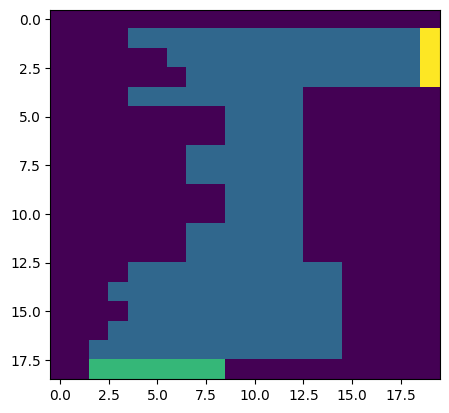

In [4]:
plt.imshow(track)

In [5]:
class Racecar:
    MAX_VELOCITY = 5
    def __init__(self, track):
        self.track = track

        self._s = []
        for i in range(track.shape[0]):
            for j in range(track.shape[1]):
                if track[i][j] == 1:
                    self._s.append((i, j))

        self.reset()
        self.action_set = [(i, j) for i in [0, 1, -1] for j in [0, 1, -1]]

    
    def step(self, action):
        max_vert, max_horiz = self.track.shape
        # With prob=0.1, increments are zero
        if np.random.rand() < 0.1:
            action = (0, 0)
            
        Vx, Vy = self.state[2] + action[0], self.state[3] + action[1]
        if Vx > self.MAX_VELOCITY: Vx = self.MAX_VELOCITY
        if Vy > self.MAX_VELOCITY: Vy = self.MAX_VELOCITY
        if Vx < 0: Vx = 0
        if Vy < 0: Vy = 0
        if Vx == 0 and Vy == 0: 
            Vx, Vy = 1, 1
            
        self.state[2] = Vx
        self.state[3] = Vy

        self.state[0] -= Vy
        self.state[1] += Vx

        if self.state[0] < 0 or self.state[1] >= max_horiz or self.track[self.state[0], self.state[1]] == -1:
            self.reset()
        elif self.track[self.state[0], self.state[1]] == 2:
            return 1, self.state

        return -1, self.state


    def generate_episodes(self, policy):
        episode = []
        self.reset()
        iaction, prob = policy(self.state)
        action = self.action_set[iaction]
        episode.append(['NO REWARD', self.state.copy(), iaction, prob]) # first time step

        while True:
            reward, new_state = self.step(action)
            iaction, prob = policy(self.state)
            action = self.action_set[iaction]
            if reward == 1:
                episode.append([reward, new_state.copy(), 'NO ACTION', 0]) # terminal state
                return episode
            episode.append([reward, new_state.copy(), iaction, prob])
            
        
    def generate_and_display(self):
        pos_h, pos_v = self.state[0], self.state[1]
        cp = self.track.copy()
        cp[pos_h, pos_v] = 4
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.imshow(cp, cmap='inferno')
        ax.set_title('Track')
        
    def reset(self):
        self.state = np.zeros((4,), dtype='int32') # vert, horiz, Vx, Vy
        istart = np.random.choice(len(self._s))
        self.state[0], self.state[1] = self._s[istart]

Epsilon-soft policy, is a policy where $\pi(a|S_t) \ge \frac{\epsilon}{|A(S_t)|}$ but it can be defined as
$$
\begin{equation}
    \pi(a|S_t) = 
    \begin{cases}
        \frac{\epsilon}{|A(S_t)|} & \text{if}\ a \ne A^*\\
        1 - \epsilon + \frac{\epsilon}{|A(S_t)|} & \text{if}\ a = A^*\\
    \end{cases}
\end{equation}
$$

In [6]:
def epsilon_soft(target, num_actions, epsilon=0.1):
    def behaviour_policy(state):
        prob = np.random.rand()
        greedy_action = action = target[state[0], state[1], state[2], state[3]]
        if prob < epsilon:
            action = np.random.choice(num_actions)
            pi = epsilon / num_actions
            if action == greedy_action: pi += 1 - epsilon
            return action, pi
        else:
            action = greedy_action
            pi = 1 - epsilon + epsilon / num_actions
            return action, pi
    return behaviour_policy

In [7]:
def off_policy_mc(track, episodes=10000, gamma=1.0, epsilon=0.1, Q=None):
    env = Racecar(track)
    num_actions = len(env.action_set)
    max_vert, max_horiz = track.shape
    if Q is None:
        Q = np.random.randn(max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1, num_actions) - 1000
    policy = np.argmax(Q, axis=-1)
    C = np.zeros((max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1, num_actions), dtype='float64')

    reward_hist = []

    for episode in range(episodes):
        # behaviour = np.random.dirichlet(np.ones(num_actions), size=(max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1))
        behaviour = epsilon_soft(policy, num_actions, epsilon)
        ep = env.generate_episodes(behaviour)
        reward_hist.append(sum([x[0] for x in ep[1:]])) # summation of the rewards until termination
        G = 0.0
        W = 1.0
        for t in reversed(range(len(ep) - 1)):
            reward = ep[t + 1][0]
            state = ep[t][1]
            action = ep[t][2]
            prob = ep[t][-1]
            G = reward + gamma * G
            C[state[0], state[1], state[2], state[3], action] += W
            Q[state[0], state[1], state[2], state[3], action] += (W / C[state[0], state[1], state[2], state[3], action]) * (G - Q[state[0], state[1], state[2], state[3], action])
            policy[state[0], state[1], state[2], state[3]] = np.argmax(Q[state[0], state[1], state[2], state[3]])
            if action != policy[state[0], state[1], state[2], state[3]]: break
            W = W * (1 / prob)

        print(f'\rEpisode: {episode + 1 : > 6} REWARD: {reward_hist[-1] : > 5}', end='')

    return policy, Q, reward_hist

In [8]:
policy, Q, reward_hist = off_policy_mc(track, episodes=10_000_000)

Episode:  10000000 AVG:   -14

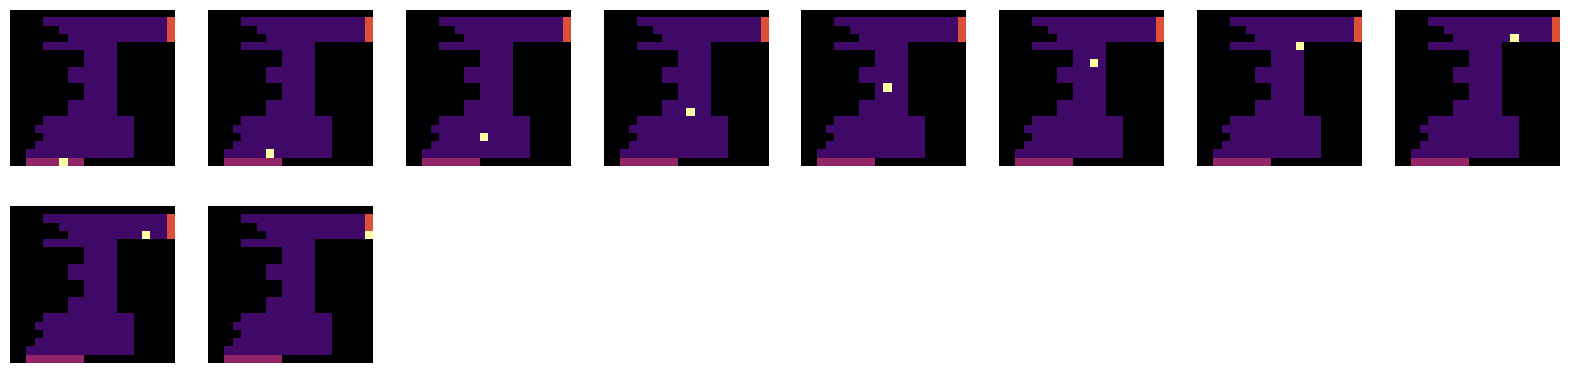

In [9]:
env = Racecar(track)
num_actions = len(env.action_set)
general_policy = epsilon_soft(policy, num_actions, epsilon=0.0)
ep = env.generate_episodes(general_policy)

fig = plt.figure(figsize=(20, 20))
cnt = 1
for e in ep:
    _, s, a, p = e
    pos_vert, pos_horiz = s[0], s[1]
    t = env.track.copy()
    t[pos_vert, pos_horiz] = 4
    ax = plt.subplot(8, 8, cnt)
    ax.grid(c='white')
    ax.imshow(t, cmap='inferno')
    ax.axis('off')
    cnt += 1

In [10]:
def plot_history(reward_history):
    fig = plt.figure()
    fontdict = {'fontsize': 11, 'fontweight': 'bold'}
    ax = plt.subplot(111)
    ax.set_title('Reward per episode', fontdict=fontdict)
    ax.set_xlabel('episode', fontdict=fontdict)
    ax.set_ylabel('reward', fontdict=fontdict)
    ax.semilogx(range(len(reward_history)), reward_history)
    ax.grid(c='lightgray')
    ax.set_ylim(ymin=-1000, ymax=1)
    ax.margins(0.01)

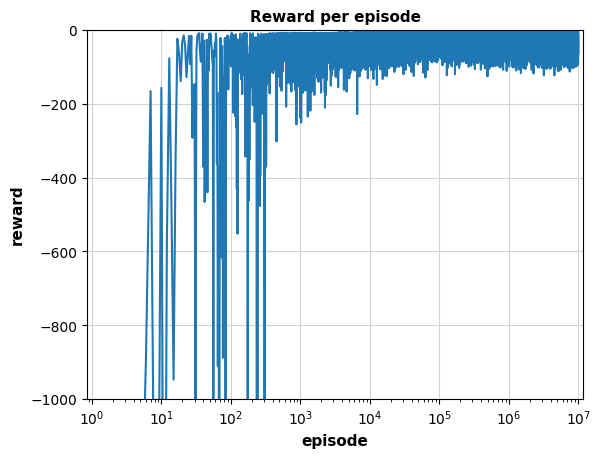

In [11]:
plot_history(reward_hist)